The code is contributed by Anders Kaestner from PSI showing the correct parameters for the Anisotropic diffusion filter and how it looks compared to other filters

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings

def anisodiff(img,niter=1,kappa=50,gamma=0.1,step=(1.,1.),sigma=0, option=1,ploton=False):
	"""
	Anisotropic diffusion.

	Usage:
	imgout = anisodiff(im, niter, kappa, gamma, option)

	Arguments:
	        img    - input image
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the image will be plotted on every iteration

	Returns:
	        imgout   - diffused image.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x and y axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference: 
	P. Perona and J. Malik. 
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence, 
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi  
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.       
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if img.ndim == 3:
		warnings.warn("Only grayscale images allowed, converting to 2D matrix")
		img = img.mean(2)

	# initialize output array
	img = img.astype('float32')
	imgout = img.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(imgout)
	deltaE = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	gS = np.ones_like(imgout)
	gE = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(img,interpolation='nearest')
		ih = ax2.imshow(imgout,interpolation='nearest',animated=True)
		ax1.set_title("Original image")
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaS[:-1,: ] = np.diff(imgout,axis=0)
		deltaE[: ,:-1] = np.diff(imgout,axis=1)

		if 0<sigma:
			deltaSf=flt.gaussian_filter(deltaS,sigma);
			deltaEf=flt.gaussian_filter(deltaE,sigma);
		else: 
			deltaSf=deltaS;
			deltaEf=deltaE;
			
		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gS = np.exp(-(deltaSf/kappa)**2.)/step[0]
			gE = np.exp(-(deltaEf/kappa)**2.)/step[1]
		elif option == 2:
			gS = 1./(1.+(deltaSf/kappa)**2.)/step[0]
			gE = 1./(1.+(deltaEf/kappa)**2.)/step[1]

		# update matrices
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'North/West' by one
		# pixel. don't as questions. just do it. trust me.
		NS[:] = S
		EW[:] = E
		NS[1:,:] -= S[:-1,:]
		EW[:,1:] -= E[:,:-1]

		# update the image
		imgout += gamma*(NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(imgout)
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return imgout

def anisodiff3(stack,niter=1,kappa=50,gamma=0.1,step=(1.,1.,1.),option=1,ploton=False):
	"""
	3D Anisotropic diffusion.

	Usage:
	stackout = anisodiff(stack, niter, kappa, gamma, option)

	Arguments:
	        stack  - input stack
	        niter  - number of iterations
	        kappa  - conduction coefficient 20-100 ?
	        gamma  - max value of .25 for stability
	        step   - tuple, the distance between adjacent pixels in (z,y,x)
	        option - 1 Perona Malik diffusion equation No 1
	                 2 Perona Malik diffusion equation No 2
	        ploton - if True, the middle z-plane will be plotted on every 
	        	 iteration

	Returns:
	        stackout   - diffused stack.

	kappa controls conduction as a function of gradient.  If kappa is low
	small intensity gradients are able to block conduction and hence diffusion
	across step edges.  A large value reduces the influence of intensity
	gradients on conduction.

	gamma controls speed of diffusion (you usually want it at a maximum of
	0.25)

	step is used to scale the gradients in case the spacing between adjacent
	pixels differs in the x,y and/or z axes

	Diffusion equation 1 favours high contrast edges over low contrast ones.
	Diffusion equation 2 favours wide regions over smaller ones.

	Reference: 
	P. Perona and J. Malik. 
	Scale-space and edge detection using ansotropic diffusion.
	IEEE Transactions on Pattern Analysis and Machine Intelligence, 
	12(7):629-639, July 1990.

	Original MATLAB code by Peter Kovesi  
	School of Computer Science & Software Engineering
	The University of Western Australia
	pk @ csse uwa edu au
	<http://www.csse.uwa.edu.au>

	Translated to Python and optimised by Alistair Muldal
	Department of Pharmacology
	University of Oxford
	<alistair.muldal@pharm.ox.ac.uk>

	June 2000  original version.       
	March 2002 corrected diffusion eqn No 2.
	July 2012 translated to Python
	"""

	# ...you could always diffuse each color channel independently if you
	# really want
	if stack.ndim == 4:
		warnings.warn("Only grayscale stacks allowed, converting to 3D matrix")
		stack = stack.mean(3)

	# initialize output array
	stack = stack.astype('float32')
	stackout = stack.copy()

	# initialize some internal variables
	deltaS = np.zeros_like(stackout)
	deltaE = deltaS.copy()
	deltaD = deltaS.copy()
	NS = deltaS.copy()
	EW = deltaS.copy()
	UD = deltaS.copy()
	gS = np.ones_like(stackout)
	gE = gS.copy()
	gD = gS.copy()

	# create the plot figure, if requested
	if ploton:
		import pylab as pl
		from time import sleep

		showplane = stack.shape[0]//2

		fig = pl.figure(figsize=(20,5.5),num="Anisotropic diffusion")
		ax1,ax2 = fig.add_subplot(1,2,1),fig.add_subplot(1,2,2)

		ax1.imshow(stack[showplane,...].squeeze(),interpolation='nearest')
		ih = ax2.imshow(stackout[showplane,...].squeeze(),interpolation='nearest',animated=True)
		ax1.set_title("Original stack (Z = %i)" %showplane)
		ax2.set_title("Iteration 0")

		fig.canvas.draw()

	for ii in np.arange(1,niter):

		# calculate the diffs
		deltaD[:-1,: ,:  ] = np.diff(stackout,axis=0)
		deltaS[:  ,:-1,: ] = np.diff(stackout,axis=1)
		deltaE[:  ,: ,:-1] = np.diff(stackout,axis=2)

		# conduction gradients (only need to compute one per dim!)
		if option == 1:
			gD = np.exp(-(deltaD/kappa)**2.)/step[0]
			gS = np.exp(-(deltaS/kappa)**2.)/step[1]
			gE = np.exp(-(deltaE/kappa)**2.)/step[2]
		elif option == 2:
			gD = 1./(1.+(deltaD/kappa)**2.)/step[0]
			gS = 1./(1.+(deltaS/kappa)**2.)/step[1]
			gE = 1./(1.+(deltaE/kappa)**2.)/step[2]

		# update matrices
		D = gD*deltaD
		E = gE*deltaE
		S = gS*deltaS

		# subtract a copy that has been shifted 'Up/North/West' by one
		# pixel. don't as questions. just do it. trust me.
		UD[:] = D
		NS[:] = S
		EW[:] = E
		UD[1:,: ,: ] -= D[:-1,:  ,:  ]
		NS[: ,1:,: ] -= S[:  ,:-1,:  ]
		EW[: ,: ,1:] -= E[:  ,:  ,:-1]

		# update the image
		stackout += gamma*(UD+NS+EW)

		if ploton:
			iterstring = "Iteration %i" %(ii+1)
			ih.set_data(stackout[showplane,...].squeeze())
			ax2.set_title(iterstring)
			fig.canvas.draw()
			# sleep(0.01)

	return stackout

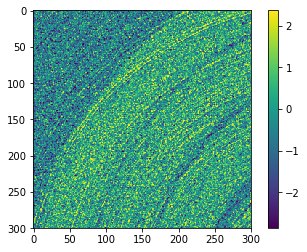

In [2]:
img=io.imread('../input/scroll.tif')
img=img.astype(float)
img=img[300:600,300:600]
m=np.mean(img)
s=np.std(img)
nimg=(img-m)/s
plt.imshow(nimg)
plt.colorbar()

CPU times: user 1.01 s, sys: 96 ms, total: 1.11 s
Wall time: 1.16 s


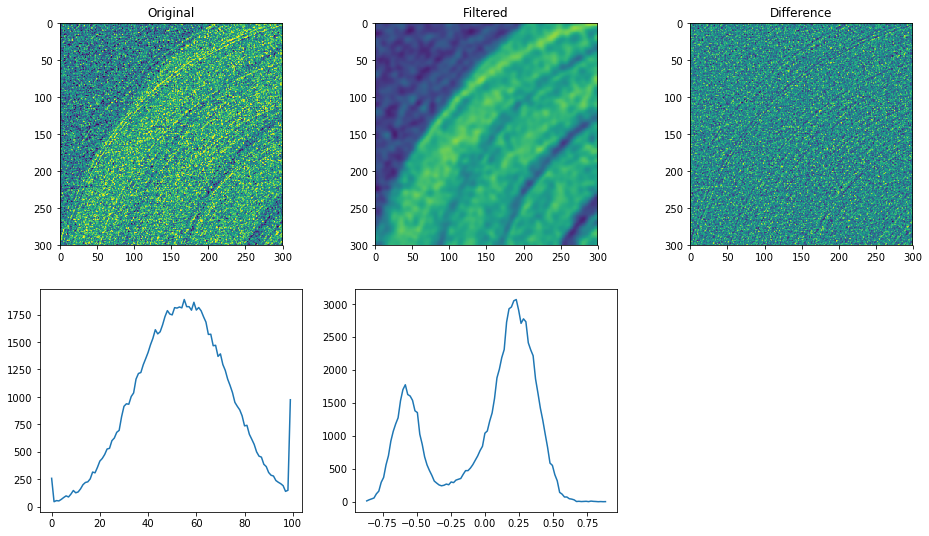

In [3]:
%%time
plt.figure(figsize=(16,9))
fimg=anisodiff(nimg,100,80,0.075,(1,1),2.5,1)
plt.subplot(2,3,1)
plt.imshow(nimg)
plt.title('Original')
plt.subplot(2,3,2)
plt.imshow(fimg,vmin=-1,vmax=1)
#plt.imshow(fimg)
plt.title('Filtered')
plt.subplot(2,3,3)
plt.imshow(fimg-nimg)
plt.title('Difference')
plt.subplot(2,3,4)
h=np.histogram(nimg,100)
plt.plot(h[0])

plt.subplot(2,3,5)
h,ax=np.histogram(fimg,100)

plt.plot(ax[0:(np.size(h))],h)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


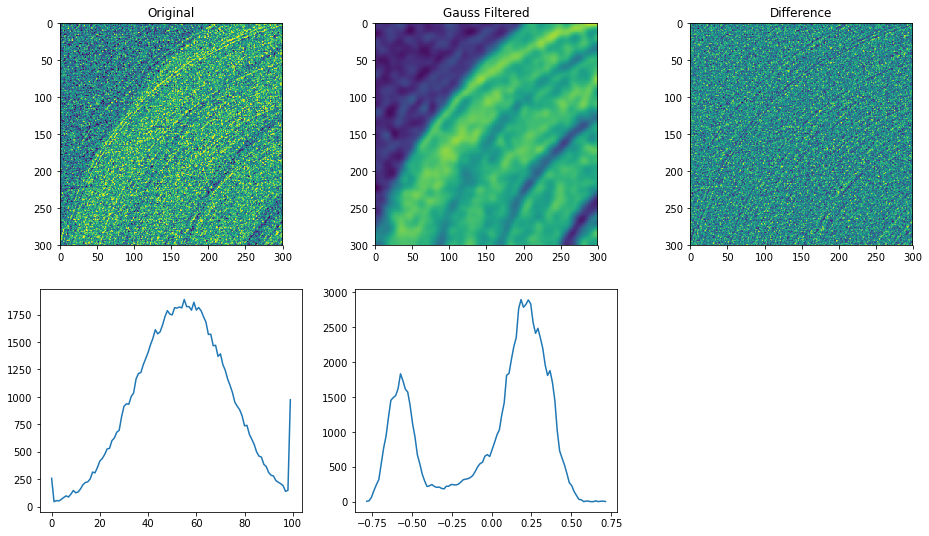

In [4]:
%time
plt.figure(figsize=(16,9))
gimg=flt.gaussian_filter(nimg,5)
plt.subplot(2,3,1)
plt.imshow(nimg)
plt.title('Original')
plt.subplot(2,3,2)
plt.imshow(gimg,vmin=-0.8,vmax=0.8)
plt.title('Gauss Filtered')
plt.subplot(2,3,3)
plt.imshow(gimg-nimg)
plt.title('Difference')

plt.subplot(2,3,4)
h=np.histogram(nimg,100)
plt.plot(h[0])

plt.subplot(2,3,5)
h,ax=np.histogram(gimg,100)

plt.plot(ax[0:(np.size(h))],h)

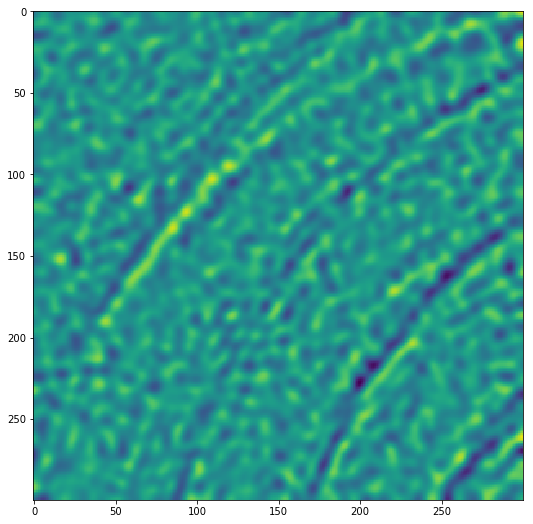

In [5]:
plt.figure(figsize=(16,9))
plt.imshow(fimg-gimg)